In [ ]:
# 필요한 라이브러리 설치
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.9 MB/s eta 0:00:00
  Preparing metadata (se

In [ ]:
import pandas as pd
import numpy as np
import re
from bertopic import BERTopic
from bertopic import _utils
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
import matplotlib.pyplot as plt

In [ ]:
# 엑셀 파일을 pandas DataFrame으로 읽어옵니다
data = pd.read_excel('ccs_raw.xlsx')

# NaN 값을 제거하거나 특정 값으로 대체합니다
data['Abstract'].fillna('', inplace=True)
data['Claims'].fillna('', inplace=True)

# 데이터를 문자열로 변환
data['Abstract'] = data['Abstract'].astype(str)
data['Claims'] = data['Claims'].astype(str)

# "publication date" 열에서 날짜 정보를 추출하여 리스트로 만듭니다
data['Publication Date'] = pd.to_datetime(data['Publication Date'], errors='coerce')

# 유효한 날짜 데이터만 남기고 NaN 값을 제거합니다
data = data.dropna(subset=['Publication Date'])

# "publication date" 열이 2022년 12월 31일 이전인 데이터만 필터링합니다
filtered_data = data[data['Publication Date'] <= '2022-12-31']

# 문장 쌍을 병합하여 하나의 텍스트로 만듭니다
docs = filtered_data['Abstract'] + ' ' + filtered_data['Claims']

In [ ]:
# docs: 텍스트 데이터 리스트 또는 배열

# Vectorization model (CountVectorizer) 설정
vectorizer_model = CountVectorizer(stop_words="english")

# 정규표현식으로 별 관련없는 단어들을 제거하기 위한 패턴 생성
stop_words_pattern = re.compile(r'\b(claim|according|second|formula|claims|method|said|subject|thereof|preferably|likelihood|group|comprising|comprises|sample|target|hours|value|optionally)\w*\b', flags=re.IGNORECASE)

# 텍스트 데이터에서 관련없는 단어를 제거하고, 나머지 단어로 구성된 리스트 생성
docs = [" ".join([word for word in re.split(r'\W+', doc) if not stop_words_pattern.match(word)]) for doc in docs]

# Class TF-IDF 모델 설정
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# 키워드를 최대한 다양하게 하고싶을때
representation_model = MaximalMarginalRelevance(diversity=0.2)
# 주요 키워드 위주로 하고싶을때
#representation_model = KeyBERTInspired()

# BERTopic 모델을 초기화하고 토픽 모델링 수행 (토픽은 10개로 만들기 위해 nr_topics=11로 세팅)
topic_model = BERTopic(vectorizer_model=vectorizer_model, nr_topics=11, verbose=True)

# 토픽 모델링 수행
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

2023-09-16 07:08:25,749 - BERTopic - Transformed documents to Embeddings
2023-09-16 07:08:58,567 - BERTopic - Reduced dimensionality
2023-09-16 07:08:58,742 - BERTopic - Clustered reduced embeddings
2023-09-16 07:09:20,202 - BERTopic - Reduced number of topics from 76 to 11


In [ ]:
# 토픽 빈도 출력
topic_freq = topic_model.get_topic_freq()
print(topic_freq)

    Topic  Count
2      -1   1563
1       0   1050
0       1    454
8       2    259
3       3    203
4       4    126
5       5     52
6       6     38
9       7     15
10      8     14
7       9     12


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1563,-1_electrode_cell_material_device,"[electrode, cell, material, device, electrolyt...",[Abstract The purpose of the present invention...
1,0,1050,0_electrode_material_battery_metal,"[electrode, material, battery, metal, carbon, ...",[Abstract A nonaqueous lithium storage element...
2,1,454,1_fuel_gas_cell_hydrogen,"[fuel, gas, cell, hydrogen, flow, cathode, ano...",[Abstract This fuel cell system which is provi...
3,2,259,2_nucleic_acid_sequence_molecule,"[nucleic, acid, sequence, molecule, nucleotide...",[Abstract Provided herein are systems and for ...
4,3,203,3_atoms_substituted_ring_aromatic,"[atoms, substituted, ring, aromatic, organic, ...",[Abstract The invention relates to an organic ...
5,4,126,4_power_energy_solar_electrical,"[power, energy, solar, electrical, dc, storage...",[Abstract This power conversion system 3 is pr...
6,5,52,5_biomass_process_cellulose_bacteria,"[biomass, process, cellulose, bacteria, lignin...",[Abstract The invention relates to novel for p...
7,6,38,6_light_layer_display_transparent,"[light, layer, display, transparent, optical, ...",[Abstract A touch sensing display panel 1 a pl...
8,7,15,7_silicon_composite_carbon_particles,"[silicon, composite, carbon, particles, proces...",[Abstract A carbon silicon composite material ...
9,8,14,8_renal_correlating_assigning_creatinine,"[renal, correlating, assigning, creatinine, se...",[Abstract The present invention relates to and...


In [ ]:
# 특정 토픽의 단어들을 출력
topic_words = topic_model.get_topic(2)
formatted_topic_words = '\n'.join([f"{word}: {score}" for word, score in topic_words])
print(formatted_topic_words)

nucleic: 0.04689207320215525
acid: 0.04529973436680241
sequence: 0.03482901261694602
molecule: 0.02444855679075115
nucleotide: 0.021079432816866882
antibody: 0.01996337347350867
binding: 0.019952140024468337
plurality: 0.01960439243600811
seq: 0.01946137326135616
id: 0.019334485257313155


In [ ]:
topic_model.visualize_barchart(top_n_topics=99, n_words=9) #, width=650

In [ ]:
# 토픽 시각화
topic_model.visualize_topics() #topics=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

In [ ]:
# 토픽 계층 시각화
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 9/9 [00:00<00:00, 94.56it/s]


In [ ]:
# 토픽 문서 시각화 (쫌 오래걸림)
topic_model.visualize_hierarchical_documents(docs, hierarchical_topics)

IndexError: ignored

In [ ]:
# 토픽 히트맵 시각화
topic_model.visualize_heatmap()

In [ ]:
#term score decline
topic_model.visualize_term_rank()

In [ ]:
#term score decline (log scale)
topic_model.visualize_term_rank(log_scale=True)

In [ ]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(docs[1], topic_token_distr[1])
df

100%|██████████| 4/4 [01:28<00:00, 22.23s/it]


In [ ]:
# To visualize the topic distributions in a document
topic_model.visualize_distribution(topic_distr[0])

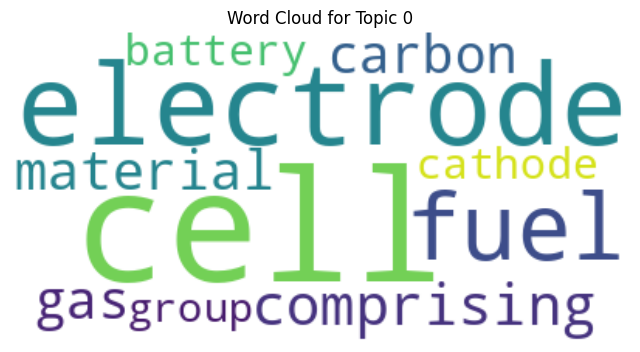

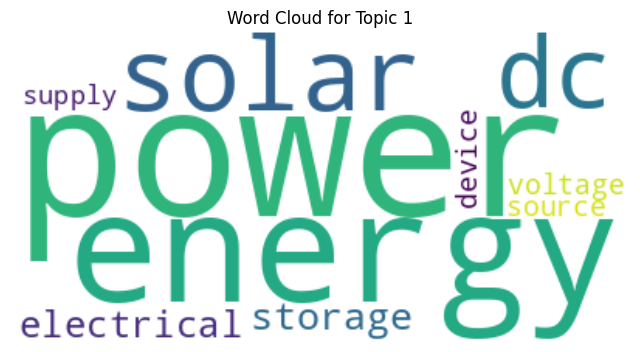

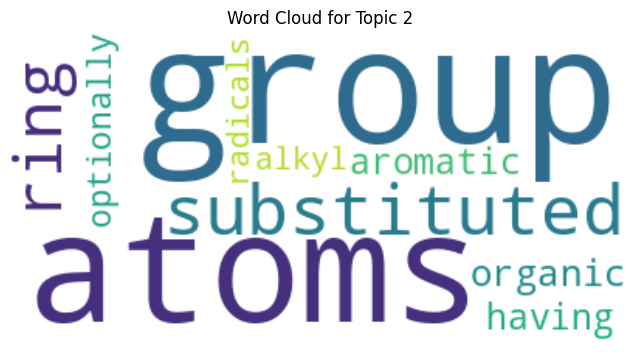

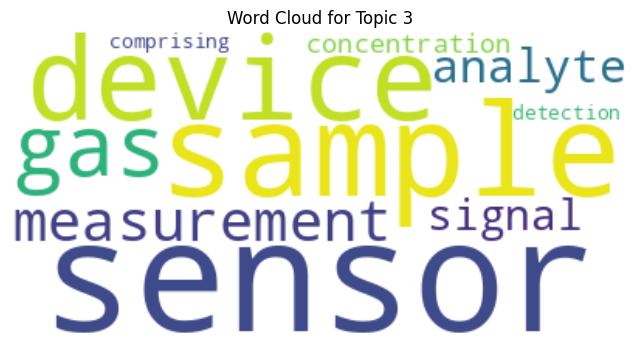

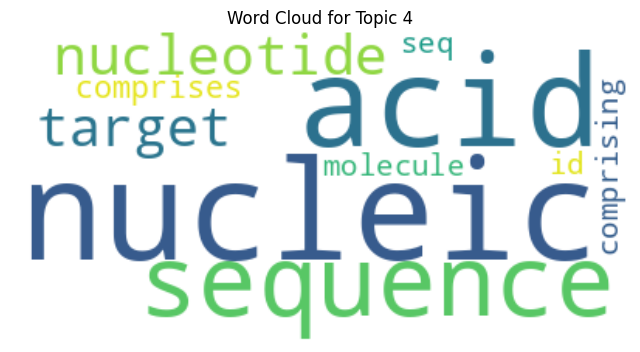

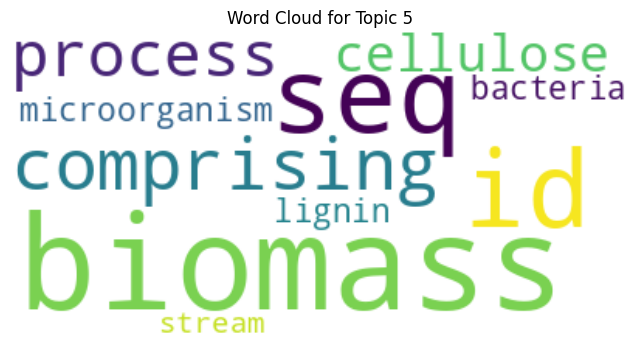

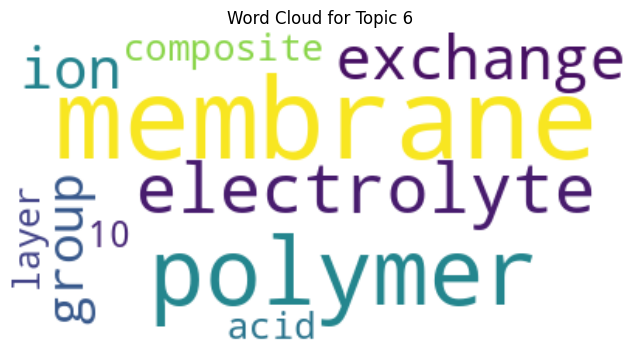

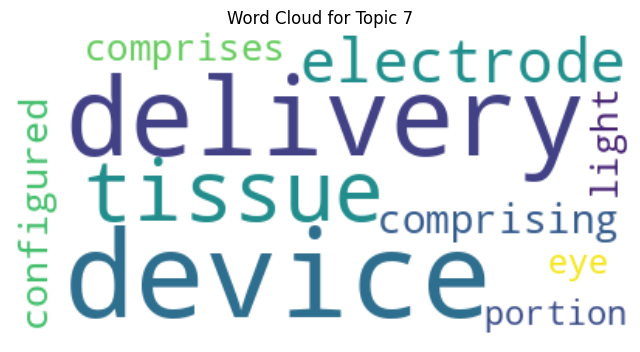

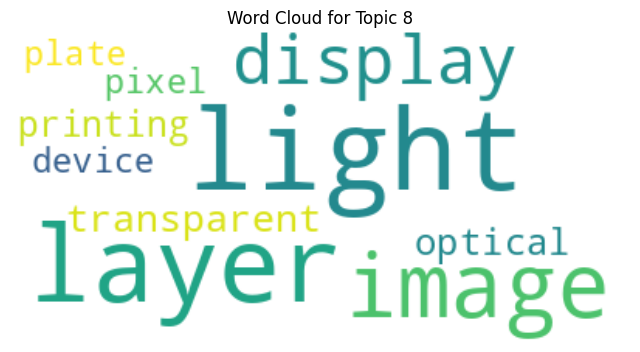

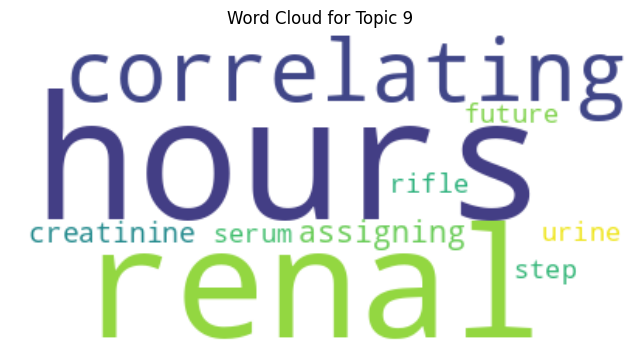

TypeError: ignored

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.figure(figsize=(8, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic}")
    plt.show()

# Show wordclouds for all topics
for topic in range(len(topic_model.get_topics())):
    create_wordcloud(topic_model, topic=topic)

<Figure size 1500x2000 with 0 Axes>

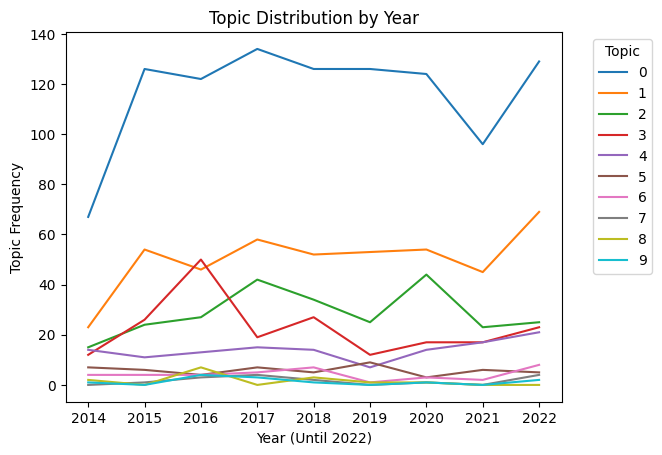

In [ ]:
# "publication date" 컬럼에서 연도 정보를 추출하여 리스트로 만듭니다
data['Publication Date'] = pd.to_datetime(data['Publication Date'])
filtered_data = data[data['Publication Date'] <= '2022-12-31']
years = filtered_data['Publication Date'].dt.year.tolist()

# 토픽 및 연도를 묶어서 데이터프레임 생성
min_length = min(len(topics), len(years))
topic_df = pd.DataFrame({'Topic': topics[:min_length], 'Year': years[:min_length]})
# Topic 0을 제외한 행을 필터링한 데이터프레임을 만듭니다
filtered_topic_df = topic_df[(topic_df['Topic'] != -1) ]

# 연도별 토픽 분포를 계산합니다
topic_distribution_by_year = filtered_topic_df.groupby(['Year', 'Topic']).size().unstack(fill_value=0)


# 시각화
plt.figure(figsize=(15, 20))
topic_distribution_by_year[topic_distribution_by_year.index <= 2022].plot(kind='line')
plt.xlabel('Year (Until 2022)')
plt.ylabel('Topic Frequency')
plt.title('Topic Distribution by Year')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
#모델 저장하기
topic_model.save("my_topics_model_0811")